This is a rough-cut analysis of Joseline's persistent infection data 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import seaborn as sns
import io
from Bio.Align.Applications import MuscleCommandline
from Bio import AlignIO
from collections import Counter
import os
from IPython.display import HTML
from bs4 import BeautifulSoup
import csv
import matplotlib.cm as cm
import scipy
from matplotlib.font_manager import fontManager, FontProperties


path = "/restricted/projectnb/lasvchal/Jill/Arial.ttf"
fontManager.addfont(path)
prop = FontProperties(fname=path)
sns.set(font=prop.get_name())

The snippet below is to get the number of fully aligning viral reads from DI-tector's list of output files. I use this to normalize between samples but isn't essential for right away

In [3]:
#for getting viral reads for bam in *temp_file_Virus.bam; do echo "File: $bam";     bamtools stats -in "$bam" | grep "Mapped reads"; done

In [4]:
samples = ['1-8-8', 'musc-2-8-8', 'musc001A','musc001B', 'musc001C', 'musc001DRE', 'musc001ERE', 'musc001F'] #more coming

This is a function to parse the sample_counts.txt file

In [5]:
def parse_dvg_file(file_path):
    # Initialize a list to store dataframes
    dataframes = []

    # Open the counts.txt file and read lines
    with open(file_path, "r") as file:
        lines = file.readlines()

    # Check if the file is empty or contains only the message
    if not lines or all(line.strip() in ["", "None or Reads number below cut-off"] for line in lines):
        return pd.DataFrame()  # Return an empty dataframe

    # Initialize variables for parsing
    current_section = None
    columns = None
    rows = []

    # Parse the file line by line
    for line in lines:
        line = line.strip()
        # Detect section headers
        if line.startswith("="):
            if rows:  # If there are rows from the previous section, add them to a dataframe
                df = pd.DataFrame(rows, columns=columns)
                df['DVG_Type'] = current_section
                dataframes.append(df)
                rows = []  # Reset rows for the next section
            if line.endswith("="):  # This is a section header
                current_section = line.strip("=").strip()
        # Detect column headers
        elif line.startswith("DVG's type"):
            columns = line.split("\t")
        # Detect data rows
        elif line and not line.startswith("="):
            rows.append(line.split("\t"))

    # Add the last section
    if rows:
        df = pd.DataFrame(rows, columns=columns)
        df['DVG_Type'] = current_section
        dataframes.append(df)

    # Combine all dataframes
    combined_df = pd.concat(dataframes, ignore_index=True) if dataframes else pd.DataFrame()

    return combined_df

In [9]:
all_samples = pd.DataFrame()

for sample in samples: 
    counts = sample + "_counts.txt"
    a = parse_dvg_file(counts)
    a['Sample'] = sample
    all_samples = pd.concat([all_samples, a], axis = 0, ignore_index = True)

This makes one giant counts table from all the samples. It will have other types of DVGs that are not sgmRNAs

In [10]:
#cleaning all samples 
all_samples['Counts'] = all_samples['Counts'].astype(int)
all_samples['BP_Pos'] = all_samples['BP_Pos'].astype(int)
all_samples['RI_Pos'] = all_samples['RI_Pos'].astype(int)
#Getting rid of potential false positives
all_samples = all_samples[all_samples['Counts'] > 1]

In [11]:
#time to normalize + get meta data 
info = pd.read_csv('musc1_edpi_for_samples_mod(2).csv')
info['Colors'] = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"]
info
info.loc[7, 'Sample'] = '1-8-8'
info

,sample_og_name,EDPI,sample type,Sample,date,virus,region,viral_reads,Colors
0,B,312,NP,musc001B,2021-03-23,ncov,North America,3988096,#1f77b4
1,A,401,NP,musc001A,2021-06-20,ncov,North America,4068059,#ff7f0e
2,C,522,NP,musc001C,2021-10-19,ncov,North America,2171386,#2ca02c
3,F,640,MT,musc001F,2022-02-14,ncov,North America,2302209,#d62728
4,H,750,MT,musc-2-8-8,2022-08-08,ncov,North America,2191902,#9467bd
5,D,630,NP,musc001DRE,2022-02-04,ncov,North America,1705552,#8c564b
6,E,630,throat,musc001ERE,2022-02-04,ncov,North America,2530616,#e377c2
7,G,750,MT,1-8-8,2022-08-08,ncov,North America,4970458,#7f7f7f


In [12]:
all_samples = all_samples.merge(info[['Sample', 'EDPI', 'sample type', 'viral_reads', 'Colors']], on='Sample', how='left')
all_samples['norm_counts'] = all_samples['Counts']/all_samples['viral_reads']


In [13]:
#Isolating sgmRNAs
dels = all_samples[all_samples["DVG's type"] == "Deletion DVG (Fwd. strand)"]
subgenomes = dels[dels['BP_Pos'] < 86]

In [56]:
subgenomes

,DVG's type,Length,BP_Pos,RI_Pos,Delta_Positions,Ref,Counts,%_to_Virus,DVG_Type,Sample,EDPI,sample type,viral_reads,Colors,norm_counts
651,Deletion DVG (Fwd. strand),864,75,29115,29039,MN908947.3|MN908947.3,2,0.03%|0.03%,,1-8-8,750,MT,4970458,#7f7f7f,4.023774e-07
652,Deletion DVG (Fwd. strand),1709,71,28266,28194,MN908947.3|MN908947.3,3,0.05%|0.04%,,1-8-8,750,MT,4970458,#7f7f7f,6.035661e-07
653,Deletion DVG (Fwd. strand),1713,63,28254,28190,MN908947.3|MN908947.3,2,0.03%|0.03%,,1-8-8,750,MT,4970458,#7f7f7f,4.023774e-07
654,Deletion DVG (Fwd. strand),1713,64,28255,28190,MN908947.3|MN908947.3,14,0.21%|0.18%,,1-8-8,750,MT,4970458,#7f7f7f,2.816642e-06
655,Deletion DVG (Fwd. strand),1713,65,28256,28190,MN908947.3|MN908947.3,3,0.05%|0.04%,,1-8-8,750,MT,4970458,#7f7f7f,6.035661e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620,Deletion DVG (Fwd. strand),3736,77,26245,26167,MN908947.3|MN908947.3,173,13.16%|3.17%,,musc001F,640,MT,2302209,#d62728,7.514522e-05
5621,Deletion DVG (Fwd. strand),4588,77,25393,25315,MN908947.3|MN908947.3,62,4.71%|1.07%,,musc001F,640,MT,2302209,#d62728,2.693066e-05
5635,Deletion DVG (Fwd. strand),8417,65,21552,21486,MN908947.3|MN908947.3,2,0.14%|0.07%,,musc001F,640,MT,2302209,#d62728,8.687309e-07
5636,Deletion DVG (Fwd. strand),8417,74,21561,21486,MN908947.3|MN908947.3,2,0.13%|0.07%,,musc001F,640,MT,2302209,#d62728,8.687309e-07


This function parses the sample_output.txt file 

In [14]:
def output5(nhp): 
    #grabbing the _output.txt file
    output = pd.read_table(nhp + '_output.txt')
    
    #limiting the scope to only 5'cbDVGs
    output5 = output[output['DVG\'s type'] == "Deletion DVG (Fwd. strand)"]
    
    #only keeping "originally" oriented 5'cbDVGs
    output5 = output5[output5['BP_Pos'] < output5['RI_Pos']]
    
    if not output5.empty:
        #separating the sequence into its two parts
        output5[['Seg 1', 'Seg 2']] = output5['Segmentation'].str.split('|', expand=True)
        output5['Seg 1'] = output5['Seg 1'].astype(int)
        #output5['Seg 2'] = output5['Seg 2'].astype(int)

        output5[['Break', 'Rejoin']] = output5['SEQ_FL_ori'].str.extract(r'([A-Z]+)([a-z].*)')
        output5['Sample'] = nhp
    else: 
        output5['Seg 1'] = ''
        output5['Seg 2'] = ''
        output5['Break'] = ''
        output5['Rejoin'] = ''
        output5['Sample'] = ''
    #output_file = nhp + '_' + dpi + '_' + junction + '.fasta'
    return output5

In [15]:
all_samples_output = pd.DataFrame()

for sample in samples: 
    
    a = output5(sample)
    a['Sample'] = sample
    
    all_samples_output = pd.concat([all_samples_output, a], axis = 0, ignore_index = True)

Grabbing all of the sgmRNA outputs from each file. nsgm = subgenomic RNAs that map to the N region (includes potential ORF9b making sgmRNAs)

In [28]:
sgm_o = all_samples_output[all_samples_output['BP_Pos'] < 85]
nsgm = sgm_o[(sgm_o['RI_Pos'] > 28253) & (sgm_o['RI_Pos'] < 28271)]
nsgm

,DVG's type,Length,BP_Pos,RI_Pos,Delta_Positions,Segmentation,MAPQ_F,MAPQ_L,RNAME_F,RNAME_L,...,MD_CIGAR_L,POS_F,POS_L,QNAME_F,SEQ_FL_ori,Seg 1,Seg 2,Break,Rejoin,Sample
3,Deletion DVG (Fwd. strand),1713,75,28266,28190,36|38,37,37,MN908947.3,MN908947.3,...,5^AA33,40,28266,NB501742:466:HVVHGAFX3:1:11101:1128:1950,CTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACaaactaatgt...,36,38,CTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAAC,aaactaatgtctgataatggaccccaaaatcagcgaaa,1-8-8
31,Deletion DVG (Fwd. strand),1713,75,28266,28190,23|51,37,37,MN908947.3,MN908947.3,...,5^AA46,53,28266,NB501742:466:HVVHGAFX3:1:11101:17679:15499,GTAGATCTGTTCTCTAAACGAACaaactaatgtctgataatggacc...,23,51,GTAGATCTGTTCTCTAAACGAAC,aaactaatgtctgataatggaccccaaaatcagcgaaatgcacccc...,1-8-8
45,Deletion DVG (Fwd. strand),1713,75,28266,28190,36|38,37,37,MN908947.3,MN908947.3,...,5^AA33,40,28266,NB501742:466:HVVHGAFX3:1:11102:26721:1958,CTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACaaactaatgt...,36,38,CTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAAC,aaactaatgtctgataatggaccccaaaatcagcgaaa,1-8-8
58,Deletion DVG (Fwd. strand),1713,75,28266,28190,26|48,37,37,MN908947.3,MN908947.3,...,5^AA43,50,28266,NB501742:466:HVVHGAFX3:1:11102:9795:7251,CTTGTAGATCTGTTCTCTAAACGAACaaactaatgtctgataatgg...,26,48,CTTGTAGATCTGTTCTCTAAACGAAC,aaactaatgtctgataatggaccccaaaatcagcgaaatgcaccccgc,1-8-8
84,Deletion DVG (Fwd. strand),1713,75,28266,28190,36|38,37,37,MN908947.3,MN908947.3,...,5^AA33,40,28266,NB501742:466:HVVHGAFX3:1:11102:2552:19246,CTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACaaactaatgt...,36,38,CTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAAC,aaactaatgtctgataatggaccccaaaatcagcgaaa,1-8-8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93154,Deletion DVG (Fwd. strand),1713,75,28266,28190,28|46,37,37,MN908947.3,MN908947.3,...,46,48,28266,NB501742:461:HVVFKAFX3:4:21611:12713:11206,CTCTTGTAGATCTGTTCTCTAAACGAACaaactaaaatgtctgata...,28,46,CTCTTGTAGATCTGTTCTCTAAACGAAC,aaactaaaatgtctgataatggaccccaaaatcagcgaaatgcacc,musc001F
93156,Deletion DVG (Fwd. strand),1713,75,28266,28190,20|54,37,37,MN908947.3,MN908947.3,...,54,56,28266,NB501742:461:HVVFKAFX3:4:21611:12575:11924,GATCTGTTCTCTAAACGAACaaactaaaatgtctgataatggaccc...,20,54,GATCTGTTCTCTAAACGAAC,aaactaaaatgtctgataatggaccccaaaatcagcgaaatgcacc...,musc001F
93183,Deletion DVG (Fwd. strand),1713,75,28266,28190,28|46,37,37,MN908947.3,MN908947.3,...,5^AA41,48,28266,NB501742:461:HVVFKAFX3:4:21612:2427:7418,CTCTTGTAGATCTGTTCTCTAAACGAACaaactaatgtctgataat...,28,46,CTCTTGTAGATCTGTTCTCTAAACGAAC,aaactaatgtctgataatggaccccaaaatcagcgaaatgcacccc,musc001F
93187,Deletion DVG (Fwd. strand),1713,75,28266,28190,44|30,37,37,MN908947.3,MN908947.3,...,30,32,28266,NB501742:461:HVVFKAFX3:4:21612:26495:9191,CCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACaa...,44,30,CCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAAC,aaactaaaatgtctgataatggaccccaaa,musc001F


In [29]:
# Mapping prefixes to types
nsgm['type'] = nsgm['Rejoin'].apply(
    lambda x: 3 if 'aaactaat' in x else #this is the double deletion that we see in Joseline's genomics data
              2 if 'aaactaaat' in x else #this is the single deletion that we see in Alpha
              1 if 'aaactaaaat' in x else None #this is the wild type
)

nsgm


/scratch/362940.1.ood/ipykernel_2466661/2423523489.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nsgm['type'] = nsgm['Rejoin'].apply(


,DVG's type,Length,BP_Pos,RI_Pos,Delta_Positions,Segmentation,MAPQ_F,MAPQ_L,RNAME_F,RNAME_L,...,POS_F,POS_L,QNAME_F,SEQ_FL_ori,Seg 1,Seg 2,Break,Rejoin,Sample,type
3,Deletion DVG (Fwd. strand),1713,75,28266,28190,36|38,37,37,MN908947.3,MN908947.3,...,40,28266,NB501742:466:HVVHGAFX3:1:11101:1128:1950,CTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACaaactaatgt...,36,38,CTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAAC,aaactaatgtctgataatggaccccaaaatcagcgaaa,1-8-8,3.0
31,Deletion DVG (Fwd. strand),1713,75,28266,28190,23|51,37,37,MN908947.3,MN908947.3,...,53,28266,NB501742:466:HVVHGAFX3:1:11101:17679:15499,GTAGATCTGTTCTCTAAACGAACaaactaatgtctgataatggacc...,23,51,GTAGATCTGTTCTCTAAACGAAC,aaactaatgtctgataatggaccccaaaatcagcgaaatgcacccc...,1-8-8,3.0
45,Deletion DVG (Fwd. strand),1713,75,28266,28190,36|38,37,37,MN908947.3,MN908947.3,...,40,28266,NB501742:466:HVVHGAFX3:1:11102:26721:1958,CTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACaaactaatgt...,36,38,CTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAAC,aaactaatgtctgataatggaccccaaaatcagcgaaa,1-8-8,3.0
58,Deletion DVG (Fwd. strand),1713,75,28266,28190,26|48,37,37,MN908947.3,MN908947.3,...,50,28266,NB501742:466:HVVHGAFX3:1:11102:9795:7251,CTTGTAGATCTGTTCTCTAAACGAACaaactaatgtctgataatgg...,26,48,CTTGTAGATCTGTTCTCTAAACGAAC,aaactaatgtctgataatggaccccaaaatcagcgaaatgcaccccgc,1-8-8,3.0
84,Deletion DVG (Fwd. strand),1713,75,28266,28190,36|38,37,37,MN908947.3,MN908947.3,...,40,28266,NB501742:466:HVVHGAFX3:1:11102:2552:19246,CTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACaaactaatgt...,36,38,CTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAAC,aaactaatgtctgataatggaccccaaaatcagcgaaa,1-8-8,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93154,Deletion DVG (Fwd. strand),1713,75,28266,28190,28|46,37,37,MN908947.3,MN908947.3,...,48,28266,NB501742:461:HVVFKAFX3:4:21611:12713:11206,CTCTTGTAGATCTGTTCTCTAAACGAACaaactaaaatgtctgata...,28,46,CTCTTGTAGATCTGTTCTCTAAACGAAC,aaactaaaatgtctgataatggaccccaaaatcagcgaaatgcacc,musc001F,1.0
93156,Deletion DVG (Fwd. strand),1713,75,28266,28190,20|54,37,37,MN908947.3,MN908947.3,...,56,28266,NB501742:461:HVVFKAFX3:4:21611:12575:11924,GATCTGTTCTCTAAACGAACaaactaaaatgtctgataatggaccc...,20,54,GATCTGTTCTCTAAACGAAC,aaactaaaatgtctgataatggaccccaaaatcagcgaaatgcacc...,musc001F,1.0
93183,Deletion DVG (Fwd. strand),1713,75,28266,28190,28|46,37,37,MN908947.3,MN908947.3,...,48,28266,NB501742:461:HVVFKAFX3:4:21612:2427:7418,CTCTTGTAGATCTGTTCTCTAAACGAACaaactaatgtctgataat...,28,46,CTCTTGTAGATCTGTTCTCTAAACGAAC,aaactaatgtctgataatggaccccaaaatcagcgaaatgcacccc,musc001F,3.0
93187,Deletion DVG (Fwd. strand),1713,75,28266,28190,44|30,37,37,MN908947.3,MN908947.3,...,32,28266,NB501742:461:HVVFKAFX3:4:21612:26495:9191,CCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACaa...,44,30,CCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAAC,aaactaaaatgtctgataatggaccccaaa,musc001F,1.0


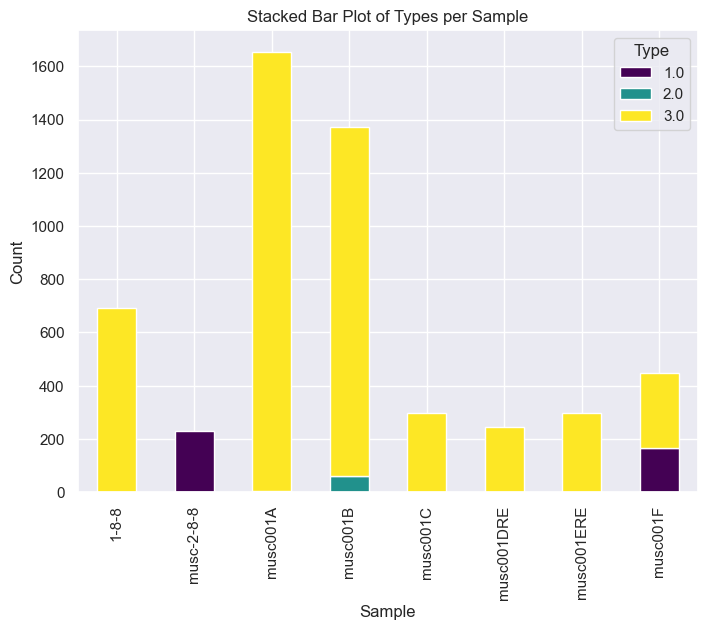

In [30]:
# Count occurrences of each type per sample
type_counts = nsgm.groupby(['Sample', 'type']).size().unstack(fill_value=0)

# Plot stacked bar chart
type_counts.plot(kind='bar', stacked=True, colormap='viridis', figsize=(8, 6))

# Labels and title
plt.xlabel('Sample')
plt.ylabel('Count') #lowkey I should have done norm count but you get the vibes
plt.title('Stacked Bar Plot of Types per Sample')
plt.legend(title='Type')

# Show plot
plt.show()



In [31]:
#this annotates other known sgmRNA regions based on the paper linked
sgm_ranges = [
    (21500, 25883, 'S'), 
    (25883, 26237, '3a'), 
    (26237, 26469, 'E'), 
    (26469, 27041, 'M'), 
    (27041, 27388, '6'), 
    (27388, 27644, '7a'), 
    (27644, 27884, '7b'),
    (27884, 28256, '8'), 
    (28256, 29530, 'N'), 
    (29530, 38000, '10')
] #https://www.nature.com/articles/s41467-020-19883-7/figures/1

In [35]:
def assign_gene(value):
    for start, end, gene_type in sgm_ranges:
        if start <= value <= end:
            return gene_type
    return 'Unknown'  # If no match is found

# Apply function to assign gene type
sgm_o['gene'] = sgm_o['RI_Pos'].apply(assign_gene)
u = sgm_o[sgm_o['gene'] == 'Unknown']

list(u['RI_Pos'])

/scratch/362940.1.ood/ipykernel_2466661/1641575308.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sgm_o['gene'] = sgm_o['RI_Pos'].apply(assign_gene)


[11898,
 4574,
 7128,
 4022,
 20822,
 8117,
 10643,
 14373,
 20822,
 2794,
 2794,
 13624,
 4022,
 10643,
 4578,
 10643,
 3368,
 4024,
 4585,
 4574,
 3818,
 10643,
 20730,
 19573,
 8753,
 2800,
 2794,
 13624,
 10643,
 13663,
 3818,
 1957,
 2794,
 13624,
 15784,
 4024,
 10026,
 2794,
 5593,
 20822,
 20730,
 2794,
 17761,
 5792,
 4022,
 5814,
 10643,
 14319,
 10748,
 10026,
 4022,
 3368,
 4585,
 10598,
 8753,
 8753,
 2794,
 10030,
 4585,
 10748,
 10026,
 13663,
 3368,
 4024,
 10598,
 10598,
 4591,
 3818,
 3368,
 10026,
 10643,
 3314,
 13624,
 10026,
 19759,
 19759,
 3368,
 2794,
 2794,
 19759,
 8117,
 19759,
 4585,
 10643,
 5792,
 10643,
 5792,
 18556,
 4585,
 19759,
 5814,
 20822,
 3314,
 3368,
 5593,
 4585,
 10026,
 4022,
 19759,
 2527,
 4574,
 20730,
 8748,
 2794,
 13663,
 6020,
 3368,
 10643,
 14373,
 8748,
 18556,
 20286,
 2794,
 10643,
 3368,
 19114,
 4591,
 19573,
 3314,
 10026,
 8757,
 8753,
 10026,
 10598,
 14373,
 20822,
 10643,
 19573,
 10026,
 3368,
 12971,
 13624,
 19114,
 13

In [77]:
sgm_o['gene'].unique()

array(['N', 'E', 'S', '7a', '7b', 'M', 'Unknown', '6', '3a', '8'],
      dtype=object)

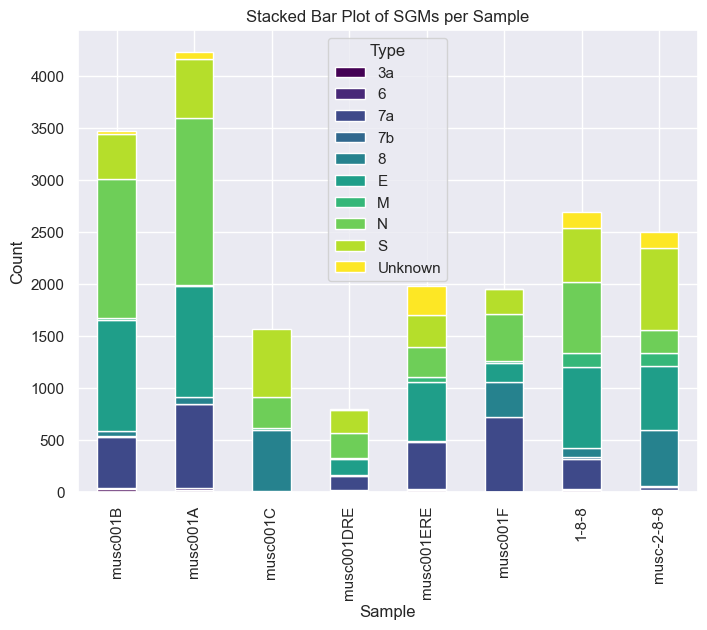

In [33]:
# Count occurrences of each type per sample
type_counts = sgm_o.groupby(['Sample', 'gene']).size().unstack(fill_value=0)
#type_counts = type_counts[type_counts[]]
# Plot stacked bar chart
sample_order = ['musc001B', 'musc001A', 'musc001C', 'musc001DRE', 'musc001ERE', 'musc001F', '1-8-8', 'musc-2-8-8']
type_counts = type_counts.reindex(sample_order)

type_counts.plot(kind='bar', stacked=True, colormap='viridis', figsize=(8, 6))

# Labels and title
plt.xlabel('Sample')
plt.ylabel('Count')
plt.title('Stacked Bar Plot of SGMs per Sample')
plt.legend(title='Type')

# Show plot
plt.show()


In [80]:
type_counts

gene,3a,6,7a,7b,8,E,M,N,S,Unknown
Sample,,,,,,,,,,
1-8-8,15,10,289,26,82,781,130,686,525,154
musc-2-8-8,10,7,33,7,543,609,125,224,788,160
musc001A,18,18,810,4,66,1065,7,1614,567,65
musc001B,28,11,494,2,56,1067,20,1335,434,22
musc001C,0,0,0,8,584,0,25,297,653,0
musc001DRE,5,15,136,0,8,153,10,240,226,5
musc001ERE,17,14,448,0,11,565,54,289,303,277
musc001F,0,1,718,0,343,176,21,452,245,1
